# AB Testing Sample 

by Thomas Pin

Adapted from UBC DSCI 554: Experimentation and Causal Inference Assignment 1 & 2

## Montana State University Library Landing Page

In [1]:
#load packages 
suppressPackageStartupMessages(library(tidyverse))

Finding free Google Analytics Click-Through-Rate information is rare due to its proprietary nature. However, using information from Scott Young’s paper ***Improving Library User Experience with A/B Testing: Principles and Process*** which includes a small freely available dataset to conduct A/B test on.

Young conducted four variations on the landing page of the University of Montana Library. Below is an image of the landing page and the area within the red box is where A/B testing would be conducted. 

![](../img/AB_Testing/01_landing_page.png)

![](../img/AB_Testing/02_var.png)

**Data**

To download the necessery data please follow the link download the file Crazy Egg data and put it into the data folder.

[data link (Crazy Egg data)](https://scholarworks.montana.edu/xmlui/handle/1/3507)

In [18]:
## Load Data 
interact <- suppressWarnings(read_csv("../data/CrazyEgg/Homepage Version 1 - Interact, 5-29-2013/Element list Homepage Version 1 - Interact, 5-29-2013.csv", col_types = cols()))
connect <- suppressWarnings(read_csv("../data/CrazyEgg/Homepage Version 2 - Connect, 5-29-2013/Element list Homepage Version 2 - Connect, 5-29-2013.csv", col_types = cols()))
learn <- suppressWarnings(read_csv("../data/CrazyEgg/Homepage Version 3 - Learn, 5-29-2013/Element list Homepage Version 3 - Learn, 5-29-2013.csv", col_types = cols()))
help <- suppressWarnings(read_csv("../data/CrazyEgg/Homepage Version 4 - Help, 5-29-2013/Element list Homepage Version 4 - Help, 5-29-2013.csv", col_types = cols()))
services <- suppressWarnings(read_csv("../data/CrazyEgg/Homepage Version 5 - Services, 5-29-2013/Element list Homepage Version 5 - Services, 5-29-2013.csv", col_types = cols()))

**Wrangle**

In [27]:
#Wrangle data
intract_clicks <- interact %>% 
    filter(`Name` == "INTERACT") %>% 
    select(`No. clicks`)
intract_clicks <- intract_clicks[[1]]
interact_total_clicks <- sum(interact$`No. clicks`)

connect_clicks <- connect %>% 
    filter(`Name` == "CONNECT") %>% 
    select(`No. clicks`)
connect_clicks <- connect_clicks[[1]]
connect_total_clicks <- sum(connect$`No. clicks`)

learn_clicks <- learn %>% 
    filter(`Name` == "LEARN") %>% 
    select(`No. clicks`)
learn_clicks <- learn_clicks[[1]]
learn_total_clicks <- sum(learn$`No. clicks`)

help_clicks <- help %>% 
    filter(`Name` == "HELP") %>% 
    select(`No. clicks`)
help_clicks <- help_clicks[[1]]
help_total_clicks <- sum(help$`No. clicks`)

services_clicks <- services %>% 
    filter(`Name` == "SERVICES") %>% 
    select(`No. clicks`)
services_clicks <- services_clicks[[1]]
services_total_clicks <- sum(services$`No. clicks`)
ab_test <- tibble(element = c("Interact", "Connect", "Learn", "Help", "Services"),
                  clicks = c(intract_clicks, connect_clicks, learn_clicks, help_clicks, services_clicks),
                  total_clicks = c(interact_total_clicks, connect_total_clicks, learn_total_clicks, help_total_clicks, services_total_clicks))

ab_test <- ab_test %>% 
    mutate(click_through_rate = clicks/total_clicks)

sample_sd <- sd(ab_test$click_through_rate)

ab_test <- ab_test %>% 
    mutate(low_ci = click_through_rate-(qt(0.975, df=total_clicks-1)*sample_sd/sqrt(total_clicks)),
           upper_ci = click_through_rate+(qt(0.975, df=total_clicks-1)*sample_sd/sqrt(total_clicks)))

ab_test$method <- c('Control', 'Variation', 'Variation', 'Variation', 'Variation')
ab_test$element <- factor(ab_test$element, levels = ab_test$element[order(ab_test$click_through_rate)])

In [28]:
ab_test$method <- c('Control', 'Variation', 'Variation', 'Variation', 'Variation')

In [29]:
ab_test

element,clicks,total_clicks,click_through_rate,low_ci,upper_ci,method
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Interact,42,3714,0.01130856,0.01096419,0.01165293,Control
Connect,53,1587,0.03339635,0.03286930,0.03392339,Variation
Learn,21,1652,0.01271186,0.01219531,0.01322842,Variation
Help,38,1717,0.02213162,0.02162496,0.02263829,Variation
Services,45,1348,0.03338279,0.03281085,0.03395473,Variation


**Visualization**

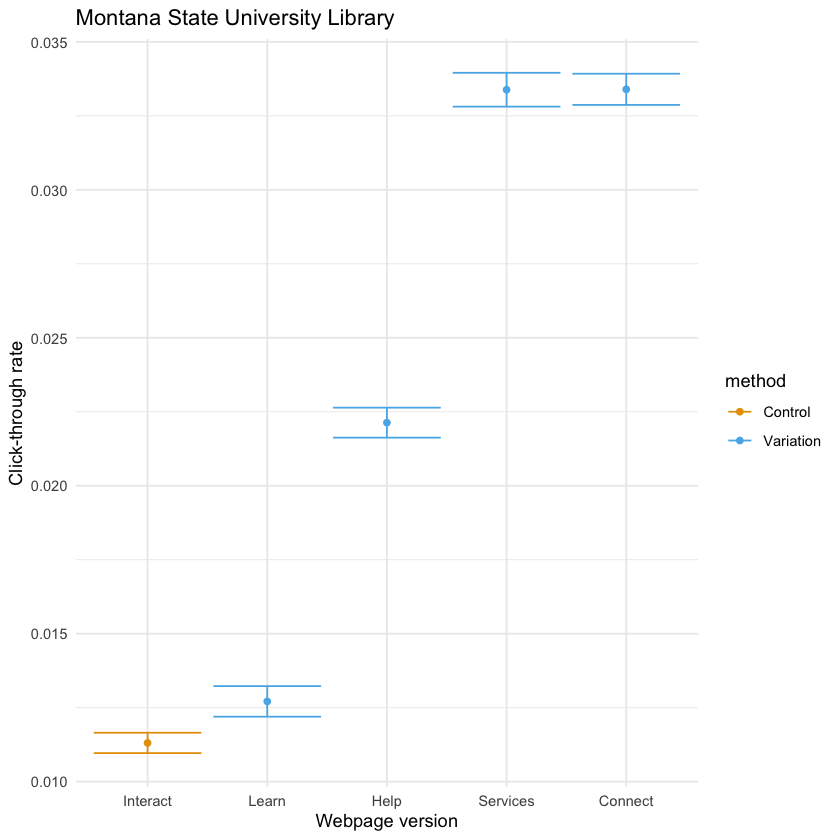

In [38]:
##Visualization

#set colour palette
cbp1 <- c("#E69F00", "#56B4E9", "#009E73",
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7")


#plot
ggplot(ab_test, aes(element, click_through_rate, color=method))+
    geom_point()+
    geom_errorbar(aes(ymin = low_ci, ymax = upper_ci))+
    xlab("Webpage version") +
    ylab("Click-through rate")+
    ggtitle("Montana State University Library")+
    theme_minimal()+
    scale_colour_manual(values = cbp1)

**Analysis**

In [40]:
##Analysis

ab_test_compairson <- ab_test %>% 
    filter(element != "Interact")

#calcuate pvalues
connect_pvalue = prop.test(x = c(intract_clicks, connect_clicks),
                           n=c(interact_total_clicks, connect_total_clicks))
connect_pvalue <- connect_pvalue$p.value

learn_pvalue = prop.test(x = c(intract_clicks, learn_clicks),
                           n=c(interact_total_clicks, learn_total_clicks))
learn_pvalue <- learn_pvalue$p.value

help_pvalue = prop.test(x = c(intract_clicks, help_clicks),
                           n = c(interact_total_clicks, help_total_clicks))
help_pvalue <- help_pvalue$p.value

services_pvalue = prop.test(x = c(intract_clicks, services_clicks),
                           n = c(interact_total_clicks, services_total_clicks))
services_pvalue <- services_pvalue$p.value

#combind and adjust for multiple hypothesis testing
ab_test_compairson <- ab_test_compairson %>%
    mutate(pval = c(connect_pvalue, learn_pvalue, help_pvalue, services_pvalue)) %>%
    mutate(adj_pval = p.adjust(pval, method = "bonferroni"))

#filter for pvalue lesss than .05
ab_test_compairson %>% 
    select(element, click_through_rate, pval, adj_pval) %>% 
    filter(adj_pval <= .05)

element,click_through_rate,pval,adj_pval
<fct>,<dbl>,<dbl>,<dbl>
Connect,0.03339635,5.367677e-08,2.147071e-07
Help,0.02213162,3.103059e-03,1.241223e-02
Services,0.03338279,1.798089e-07,7.192358e-07


**Conclusion**

> Young concludes that the library should select “service” as the new default: However, from our analysis above our statistically significant variances are “connect”, “help” or “services”. I recommend either “connect” or “service” become the new replacement for "interact" on the landing page.

Reference:

- [Scott W. H. Young Improving Library User Experience with A/B Testing: Principles and Process](https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main)

## MDS Landing Page

The UBC Master of Data Science Program served the following four ads for a four month Facebook campaign. 

![](../img/AB_Testing/03_ABfacebook_ads.png)

In [51]:
mds_ad <- tibble(ad_variant = c("A", "B", "C", "D"),
      impressions = c(11921, 6747, 2778, 29701),
      clicks = c(152, 88, 22, 450),
      click_through_rate = c(0.0128, 0.013, 0.0079, 0.0152))

mds_ad <- mds_ad %>% add_column(video = c("M", "M", "F", "F"), 
                      cta = c("Apply Now", "Apply Now", "Apply Now", "Learn More"))
mds_ad

ad_variant,impressions,clicks,click_through_rate,video,cta
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
A,11921,152,0.0128,M,Apply Now
B,6747,88,0.0130,M,Apply Now
C,2778,22,0.0079,F,Apply Now
D,29701,450,0.0152,F,Learn More


**Analysis on the Four Ads**

In [50]:
pairwise.prop.test(mds_ad$clicks, mds_ad$impressions)


	Pairwise comparisons using Pairwise comparison of proportions 

data:  mds_ad$clicks out of mds_ad$impressions 

  1     2     3    
2 0.918 -     -    
3 0.215 0.215 -    
4 0.215 0.430 0.018

P value adjustment method: holm 

Given the table above the only statistical difference between Ads are Ad C and Ad D. Therefore there is not enough statistical evidence to differentiate between the click through rate of B, C, and D.   

**Video** 

Next, we are going to check if there is a significant difference between the male in the video ad or female in the video add. 

In [61]:
#wrangle and group new table
mds_ad_video <- mds_ad %>% 
    group_by(video) %>% 
    summarize(impressions = sum(impressions),
              clicks = sum(clicks)) %>% 
    mutate(click_through_rate= clicks/impressions)

In [62]:
mds_ad_video

video,impressions,clicks,click_through_rate
<chr>,<dbl>,<dbl>,<dbl>
F,32479,472,0.01453247
M,18668,240,0.01285622


In [65]:
video_ptest <- prop.test(mds_ad_video$clicks, mds_ad_video$impressions)
print(paste0("The P-value significant's value for male or female: ", round(video_ptest$p.value, 4)))

[1] "The P-value significant's value for male or female: 0.1289"


>There is not enough statistical evidence to reject the null hypothesis that there is a difference between using a male or female subject in the ads. 

**Call To Action**

Finally, we are going to investigate if there is a statistical difference between using “Apply Now” and “Learn More” as the Call to Action button on the Ad.  

In [69]:
mds_ad_cta <- mds_ad %>% 
    group_by(cta) %>% 
    summarize(impressions = sum(impressions),
              clicks = sum(clicks)) %>% 
    mutate(click_through_rate= clicks/impressions)

In [70]:
mds_ad_cta

cta,impressions,clicks,click_through_rate
<chr>,<dbl>,<dbl>,<dbl>
Apply Now,21446,262,0.01221673
Learn More,29701,450,0.01515101


In [72]:
cta_ptest <- prop.test(mds_ad_cta$clicks, mds_ad_cta$impressions)
print(paste0("The P-value significant's value for Learn More or Apply Now: ", round(cta_ptest$p.value, 4)))

[1] "The P-value significant's value for Learn More or Apply Now: 0.0058"


>There is enough statistical evidence to reject the null hypothesis that “Apply Now” and “Learn More” have the same click through rate. In future Facebook ads, the call to action should be “Learn More” instead of “Apply Now”. 

**Conclusion**

>When designing ads there were four texts options, two video options (male and female) and two call to action options (Learn More and Apply Now). In future tests we should use sixteen different treatment groups to find the best combination of features. 